
<div class="alert alert-block alert-info">
<h1>Portfolio-Exam Customer Personality Analysis</h1>
<h2>Story and Background</h2>
Greetings! I'm Tom Ruge, the founder and CEO of TickleTech Consulting. Our mission is simple: to provide practical solutions for businesses. Recently, I had the opportunity to lead a project analyzing customer and retail data for a prominent retail company. I'm pleased to announce that our proposal was successful, and now we're ready to dive into the data.

This retail giant offers a wide range of products, catering to various needs from everyday essentials to specialized items like car tires. Their diverse product offerings attract a broad customer base, both online and offline. Through diligent data collection efforts, the company has amassed a wealth of information covering purchase channels, customer demographics, spending habits, and the effectiveness of promotional campaigns.

In this analysis, our goal is twofold. Firstly, we aim to provide the company with a comprehensive understanding of their customer base. By examining the data, we can gain insights into the preferences and behaviors of their diverse clientele. Secondly, we'll utilize advanced cluster algorithms to identify distinct customer segments and their defining characteristics. Whether it's identifying common purchasing patterns or uncovering hidden trends, our analysis will provide actionable insights to help the company tailor their offerings and improve customer engagement.

At TickleTech Consulting, we believe in the power of data-driven strategies to drive business success. Join us as we embark on this journey to enhance customer experiences and make the world a better place for businesses and consumers alike.

<h2>Table of Contents</h2>
    <ol>
        <li><a href="#yourdata"> Your Data</a>
            <ol type="a">
                <li><a href="#library_import">Import Librarys</a></li>
                <li><a href="#loading_data">Loading Data</a></li>
                <li><a href="#feature_engineering">Feature Engineering</a></li>
                <li><a href="#ida">Initial Data Analysis (IDA)</a></li>
                <li><a href="#eda">Exploratory Data Analysis (EDA)</a></li>
                <li><a href="#data_cleaning">Data Cleaning and Preprocessing</a></li>
            </ol>
        </li>
        <li><a href="#data-collection">Data Collection</a></li>
        <li><a href="#customer-segments">Customer Segments</a></li>
        <li><a href="#insights">Insights</a></li>
    </ol>

</div>

<div class="alert alert-block alert-info">
<a href="#yourdata"><h2>Your Data</h2></a>

The data you provided to me consists of 27 attributes which are enumerated in the following:

#### People

- **ID**: Unique identifier for each customer
- **Year_Birth**: Year of birth of the customer
- **Education**: Level of education attained by the customer
- **Marital_Status**: Marital status of the customer
- **Income**: Yearly household income of the customer
- **Kidhome**: Number of children in the customer's household
- **Teenhome**: Number of teenagers in the customer's household
- **Dt_Customer**: Date of customer's enrollment with the company
- **Recency**: Number of days since the customer's last purchase
- **Complain**: Indicates whether the customer complained in the last 2 years (1 for yes, 0 for no)

#### Products

- **MntWines**: Amount spent on wine in the last 2 years
- **MntFruits**: Amount spent on fruits in the last 2 years
- **MntMeatProducts**: Amount spent on meat in the last 2 years
- **MntFishProducts**: Amount spent on fish in the last 2 years
- **MntSweetProducts**: Amount spent on sweets in the last 2 years
- **MntGoldProds**: Amount spent on gold in the last 2 years

#### Promotion

- **NumDealsPurchases**: Number of purchases made with a discount
- **AcceptedCmp1-5**: Indicates whether the customer accepted the offer in each of the 5 campaigns (1 for yes, 0 for no)
- **Response**: Indicates whether the customer accepted the offer in the last campaign (1 for yes, 0 for no)

#### Place

- **NumWebPurchases**: Number of purchases made through the company’s website
- **NumCatalogPurchases**: Number of purchases made using a catalogue
- **NumStorePurchases**: Number of purchases made directly in stores
- **NumWebVisitsMonth**: Number of visits to company’s website in the last month

<a href="#library_import"><h3>Importing Librarys</h3></a>
The imports of the librarys are done in the beginning to make the following code more readable and get already an overview of what is done in the following.
</div>

In [29]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# nice way of displaying missing values
import missingno as msno
# so we can see all columns, when we display a big dataframe
pd.set_option('display.max_columns', None)
# golbaly increase the font size of the plots
plt.rcParams.update({'font.size': 22})


<div class="alert alert-block alert-info">
<a href="#loading_data"><h3>Loading Data</h3></a>
</div>


In [30]:
# specify the path to the data set
path = '/home/tomruge/Schreibtisch/Data/FH/marketing_campaign.csv'
# Using pyarrow as engine to read the data set. It is faster than the default engine.
data = pd.read_csv(path, delimiter='\t')

data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0



<div class="alert alert-block alert-info">
Set the already existing ID column to the unique primary key of the dataframe.
</div>

In [31]:
# ID already exists in the data set, so we can use it as index
data.set_index('ID', inplace=True)


<div class="alert alert-block alert-info">
Convert the two attributes 'Dt_Customer' and 'Year_Birth' to a python datetime format in order to be able to work with the provided dates.
</div>

In [32]:
# Dt_Customer is a date column, so we need to convert it to datetime
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], format='%d-%m-%Y')

# Year_Birth needs to be transformed to datetime
data['Year_Birth'] = pd.to_datetime(data['Year_Birth'], format='%Y')


<div class="alert alert-block alert-info">
In order to work more savely with the dataset the missing values should be investigated.
</div>

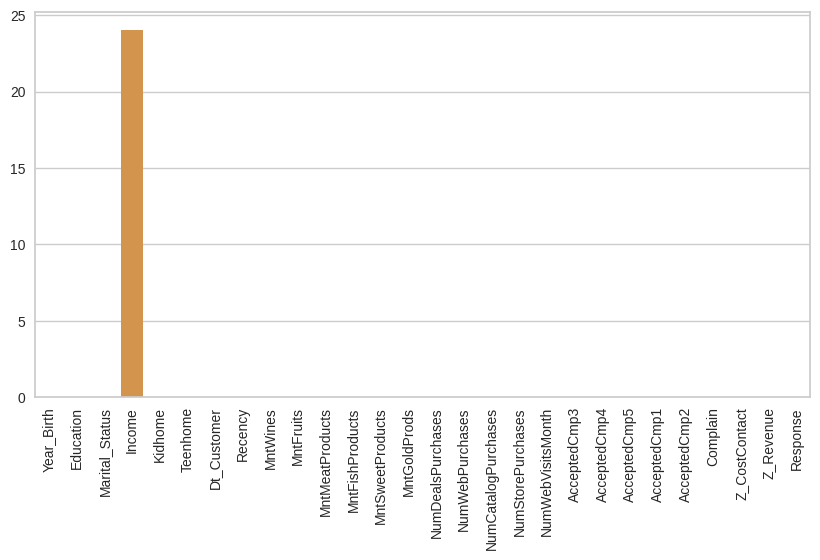

In [33]:
missing_values = data.isnull().sum()
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=missing_values.index, y=missing_values.values, ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()


<div class="alert alert-block alert-info">
It can be seen, that only the income variable contains 24 missing values. They will be dropped, since they only make up around 1 percent of all the columns of the dataset which van be seem <a href="#ida">here</a>.
</div>

In [34]:
data.dropna(inplace=True)


<div class="alert alert-block alert-info">
It can be seen, that 24 rows contain missing values in the column income. These columns will be just dropped as they only make up around 1 percent of the hole dataset. Missing values may imply that the remaining customer data is of poorer quality. <br><br>
<a id =exercise1><h2>Feature Engineering</h2>  </a id =exercise1.1>
I have derived new attributres from the already existing attributes in order to create new interesting variables, which may or not give a further insight into your customers.

- **Age**: Since the dataset only contains the dates of registerings and the dates of births, it is possible to construct the age of the customer at the day of registration.
- **MntAll**: The sum of the spendings for each customer.
- **Children**: Since the dataset contains the number of kids and teens at home it is possible to sum both up to the number of children at home
- **IsParent**: A binary variable. True when more then 1 kid or teen is at home.
- **AcceptedDeals**: Summing up all the accepted campaigns and the response variable to get the number of accepted campaigns.
- **AcceptedAnyDeal**: A binray variable. True when the customer accepted any of the deals. False otherwise. 
- **IncomePerPerson**: This variable serves for a very rough approximation of how much money one household per person living there is available.
- **LivingTogether**: True when the person is married or together or IsParent. 
</div>

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 5524 to 9405
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Year_Birth           2216 non-null   datetime64[ns]
 1   Education            2216 non-null   object        
 2   Marital_Status       2216 non-null   object        
 3   Income               2216 non-null   float64       
 4   Kidhome              2216 non-null   int64         
 5   Teenhome             2216 non-null   int64         
 6   Dt_Customer          2216 non-null   datetime64[ns]
 7   Recency              2216 non-null   int64         
 8   MntWines             2216 non-null   int64         
 9   MntFruits            2216 non-null   int64         
 10  MntMeatProducts      2216 non-null   int64         
 11  MntFishProducts      2216 non-null   int64         
 12  MntSweetProducts     2216 non-null   int64         
 13  MntGoldProds         2216 non-null 

In [36]:
# Age is difference between the Dt_Customer and Year_Birth, since it was probably the time where the measurement was taken
data['Age'] = (data['Dt_Customer'].dt.year - data['Year_Birth'].dt.year).astype(int)

# create a column for overall spending by adding all the spending columns
data['MntAll'] = data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] + data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds']

# combine children and teen to one column
data['Children'] = data['Kidhome'] + data['Teenhome'] 

# is parent or not
data['IsParent'] = np.where((data['Kidhome'] > 0) | (data['Teenhome'] > 0), 1, 0)

# how many deals accepted
data['AcceptedDeals'] = data['AcceptedCmp1'] + data['AcceptedCmp2'] + data['AcceptedCmp3'] + data['AcceptedCmp4'] + data['AcceptedCmp5'] + data['Response']

# accepted any deal or not
data['AcceptedAnyDeal'] = np.where(data['AcceptedDeals'] > 0, 1, 0)

# Living with or not
data['LivingTogether'] = np.where((data['IsParent'] > 0) | (data['Marital_Status'] != 'Together') | (data['Marital_Status'] != 'Married'), 1, 0)

# create a income per people column, the plus 1 is to avoid division by zero, should also consider marital status
data['IncomePerPerson'] = data['Income'] / (data['Children'] + 1)


<div class="alert alert-block alert-info">
<a id =exercise1><h2>Initial Data Analysis (IDA)</h2>  </a id =exercise1.1>
Now we will investigate how big the datset is.
</div>

In [37]:
print('The data set has {} rows and {} columns'.format(data.shape[0], data.shape[1]))

The data set has 2216 rows and 36 columns



<div class="alert alert-block alert-info">
After adding new columns by feature engineering and deleting 24 rows due to missing values we yield 2216 rows and 36 columns. How do the first 5 rows of the dataset look like now.
</div>

In [38]:
data.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,MntAll,Children,IsParent,AcceptedDeals,AcceptedAnyDeal,LivingTogether,IncomePerPerson
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5524,1957-01-01,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,55,1617,0,0,1,1,1,58138.0
2174,1954-01-01,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,60,27,2,1,0,0,1,15448.0
4141,1965-01-01,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,48,776,0,0,0,0,1,71613.0
6182,1984-01-01,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,30,53,1,1,0,0,1,13323.0
5324,1981-01-01,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,33,422,1,1,0,0,1,29146.5



<div class="alert alert-block alert-info">
Giving in the following a description of the dataset using statistical values. This serves only as a quick overview for the hole datset. All the features will be evaluated in detail in the exploratory data analysis part.
</div>

In [39]:
data.describe()

,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,MntAll,Children,IsParent,AcceptedDeals,AcceptedAnyDeal,LivingTogether,IncomePerPerson
count,2216,2216.000000,2216.000000,2216.000000,2216,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.0,2216.0,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.0,2216.000000
mean,1968-10-27 00:27:56.534296032,52247.251354,0.441787,0.505415,2013-07-10 11:29:27.509025280,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,2.323556,4.085289,2.671029,5.800993,5.319043,0.073556,0.074007,0.073105,0.064079,0.013538,0.009477,3.0,11.0,0.150271,44.208032,607.075361,0.947202,0.714350,0.448556,0.273014,1.0,33848.909446
min,1893-01-01 00:00:00,1730.000000,0.000000,0.000000,2012-07-30 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,16.000000,5.000000,0.000000,0.000000,0.000000,0.000000,1.0,1223.500000
25%,1959-01-01 00:00:00,35303.000000,0.000000,0.000000,2013-01-16 00:00:00,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,36.000000,69.000000,0.000000,0.000000,0.000000,0.000000,1.0,15408.375000
50%,1970-01-01 00:00:00,51381.500000,0.000000,0.000000,2013-07-08 12:00:00,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,43.000000,396.500000,1.000000,1.000000,0.000000,0.000000,1.0,24752.000000
75%,1977-01-01 00:00:00,68522.000000,1.000000,1.000000,2013-12-31 00:00:00,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,54.000000,1048.000000,1.000000,1.000000,1.000000,1.000000,1.0,39026.500000
max,1996-01-01 00:00:00,666666.000000,2.000000,2.000000,2014-06-29 00:00:00,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000,121.000000,2525.000000,3.000000,1.000000,5.000000,1.000000,1.0,333333.000000
std,NaN,25173.076661,0.536896,0.544181,NaN,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,1.923716,2.740951,2.926734,3.250785,2.425359,0.261106,0.261842,0.260367,0.244950,0.115588,0.096907,0.0,0.0,0.357417,12.023812,602.900476,0.749062,0.451825,0.892440,0.445609,0.0,25912.847005


<div class="alert alert-block alert-info">
I will dive quickly into some interesting variables:

- **Muss ich noch besser machen**
</div>

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 5524 to 9405
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Year_Birth           2216 non-null   datetime64[ns]
 1   Education            2216 non-null   object        
 2   Marital_Status       2216 non-null   object        
 3   Income               2216 non-null   float64       
 4   Kidhome              2216 non-null   int64         
 5   Teenhome             2216 non-null   int64         
 6   Dt_Customer          2216 non-null   datetime64[ns]
 7   Recency              2216 non-null   int64         
 8   MntWines             2216 non-null   int64         
 9   MntFruits            2216 non-null   int64         
 10  MntMeatProducts      2216 non-null   int64         
 11  MntFishProducts      2216 non-null   int64         
 12  MntSweetProducts     2216 non-null   int64         
 13  MntGoldProds         2216 non-null 

<div class="alert alert-block alert-info">
As one can see, we yield now 36 variables, which is a lot. It can be seen that most variables are integers with 64 bit, some are floats, string objects and datetimes. It would be possible to change the datatypes to more efficient ones but which is due to the small dataset not needed. There are many binary variables which could be encoded as such. In the follwing we will continue with the eploratory data analysis to gain a better understanding of the data.
</div>

<div class="alert alert-block alert-info">
<h2>Exploratory Data Analysis (EDA)</h2>
As one was able to see, the dataset is high dimensional and it wont be possible to go much into detail. My goal is it to adress each variable in the following at least once, so you now what each variable is about. I have devided the exploratory data analsysis into 2 major parts. At first I will conduct a univariat data analysis subdivided into the categorical and numerical variables. Secondly I will conduct a mulitvariat anslysis like investigating scatterplots, heatmaps, etc... to see how the variables behave to each other.
<h3>Univariate Data Analysis</h3>
A look into the distributions of the variables.
<h4>Categorical Variables</h4>

At first we will take a look into the distribution of the categorial variables.
</div>


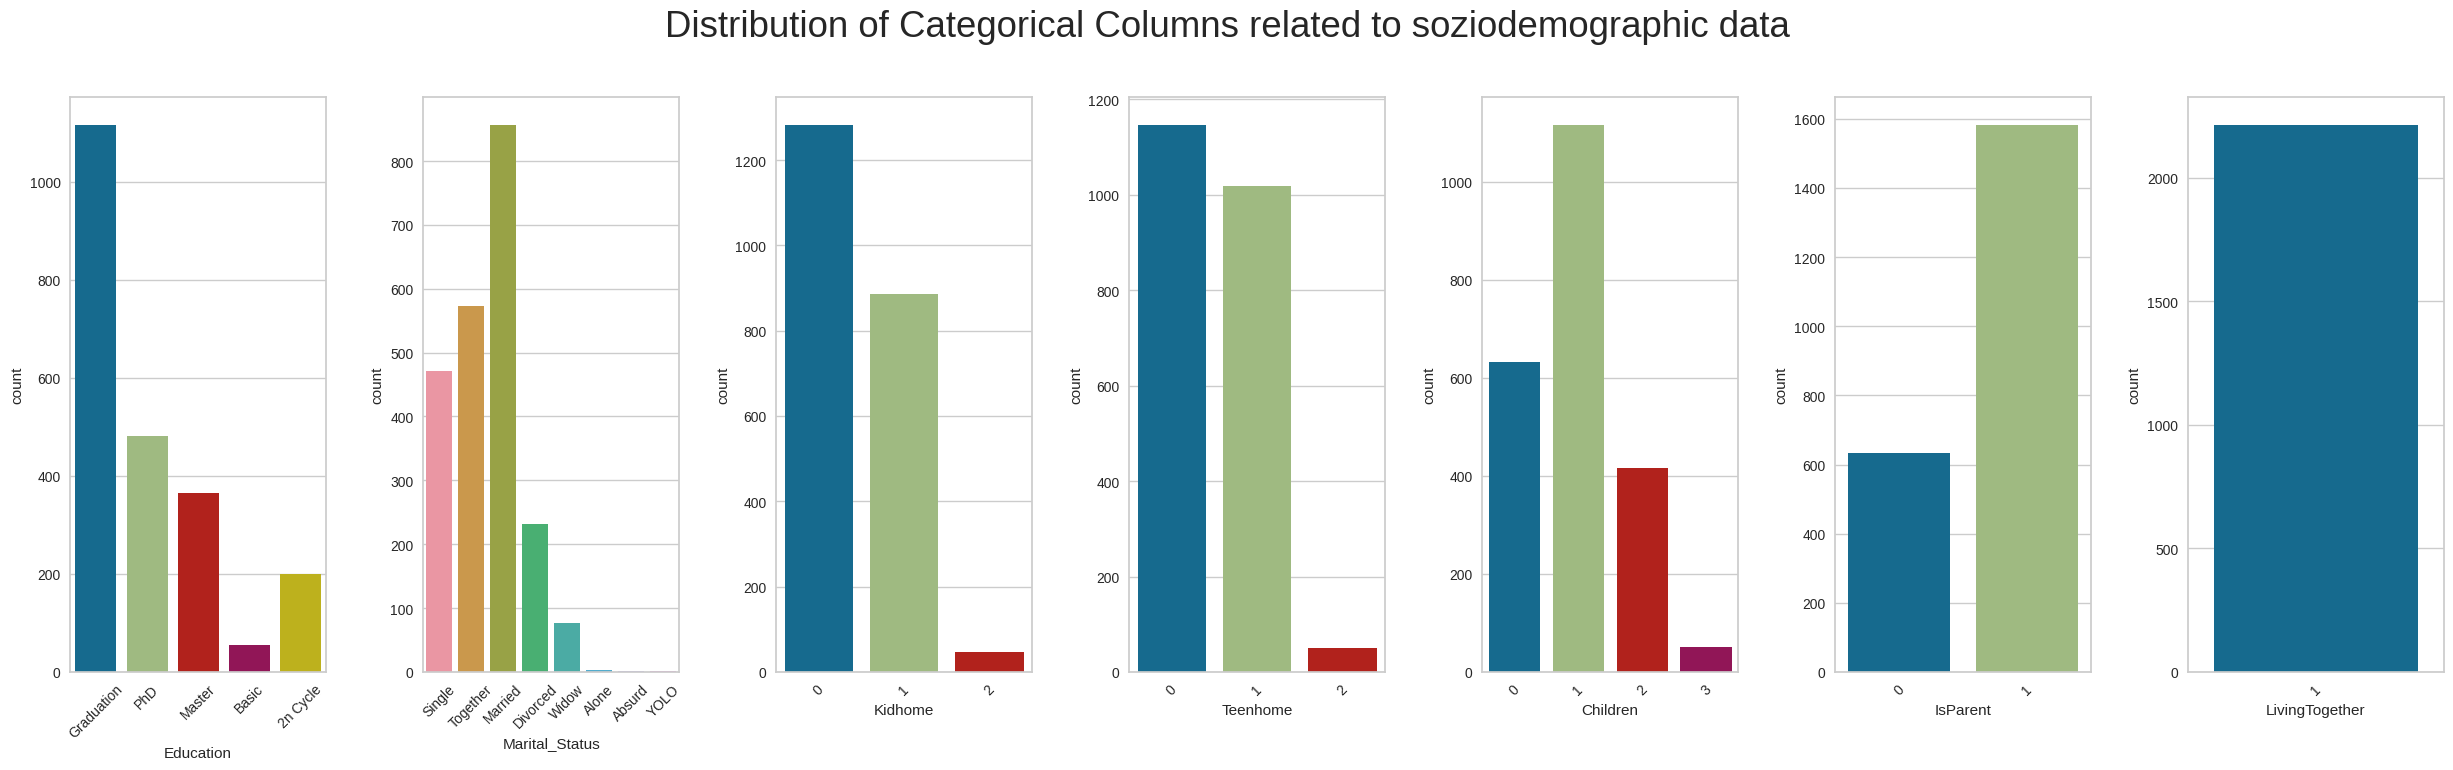

Number of people who complained: 21


In [41]:
cal_cols = ['Education', 'Marital_Status', 'Kidhome', 'Teenhome','Children', 'IsParent', 'LivingTogether']
fig, ax = plt.subplots(1, len(cal_cols), figsize=(25, 8))
fig.suptitle('Distribution of Categorical Columns related to soziodemographic data')
for col in enumerate(cal_cols):
    sns.countplot(data=data, x=col[1], ax=ax[col[0]])
    ax[col[0]].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

print('Number of people who complained: {}'.format(data['Complain'].sum()))

<div class="alert alert-block alert-info">
<h4>Thoughts</h4>

- **Education**: It seems like way too many people do have a PhD. It could be possible that the people who took the survey were trolling and therefore distorting the measurement. According to [this website](https://worldpopulationreview.com/country-rankings/phd-percentage-by-country) the country with highest percentage of phds is slovenia with 3.6%. If it can be expected that this survey was done by people which in average reflect the populations education, it means that the attribute of education here is of less good quality. But since no more detailed information of this dataset is available no coclusions can be drawn.

- **Marital_Status**: Most people seem to be married or in a relationship. Otherwise the people are single, divorced and even widows. There are also entries which state 'Alone'. This could be probably sorted to single. There are also some outliers like absurd and yolo, which should be filetred out.

- **Kidhome - Teehnome - Children - IsParent**: Most people dont have a kid at home and a teen at home. But most people have at least one kid or teen at home. Some even 2 or 3.

- **LivingTogether**: It can be concluded that all customers are either in a relationship or have children. Therefore this variable does not have any meaning for clustering pourposes.

Now we will take a look into the attributes, which are related to the campaigns, products and purchase channels.
</div>


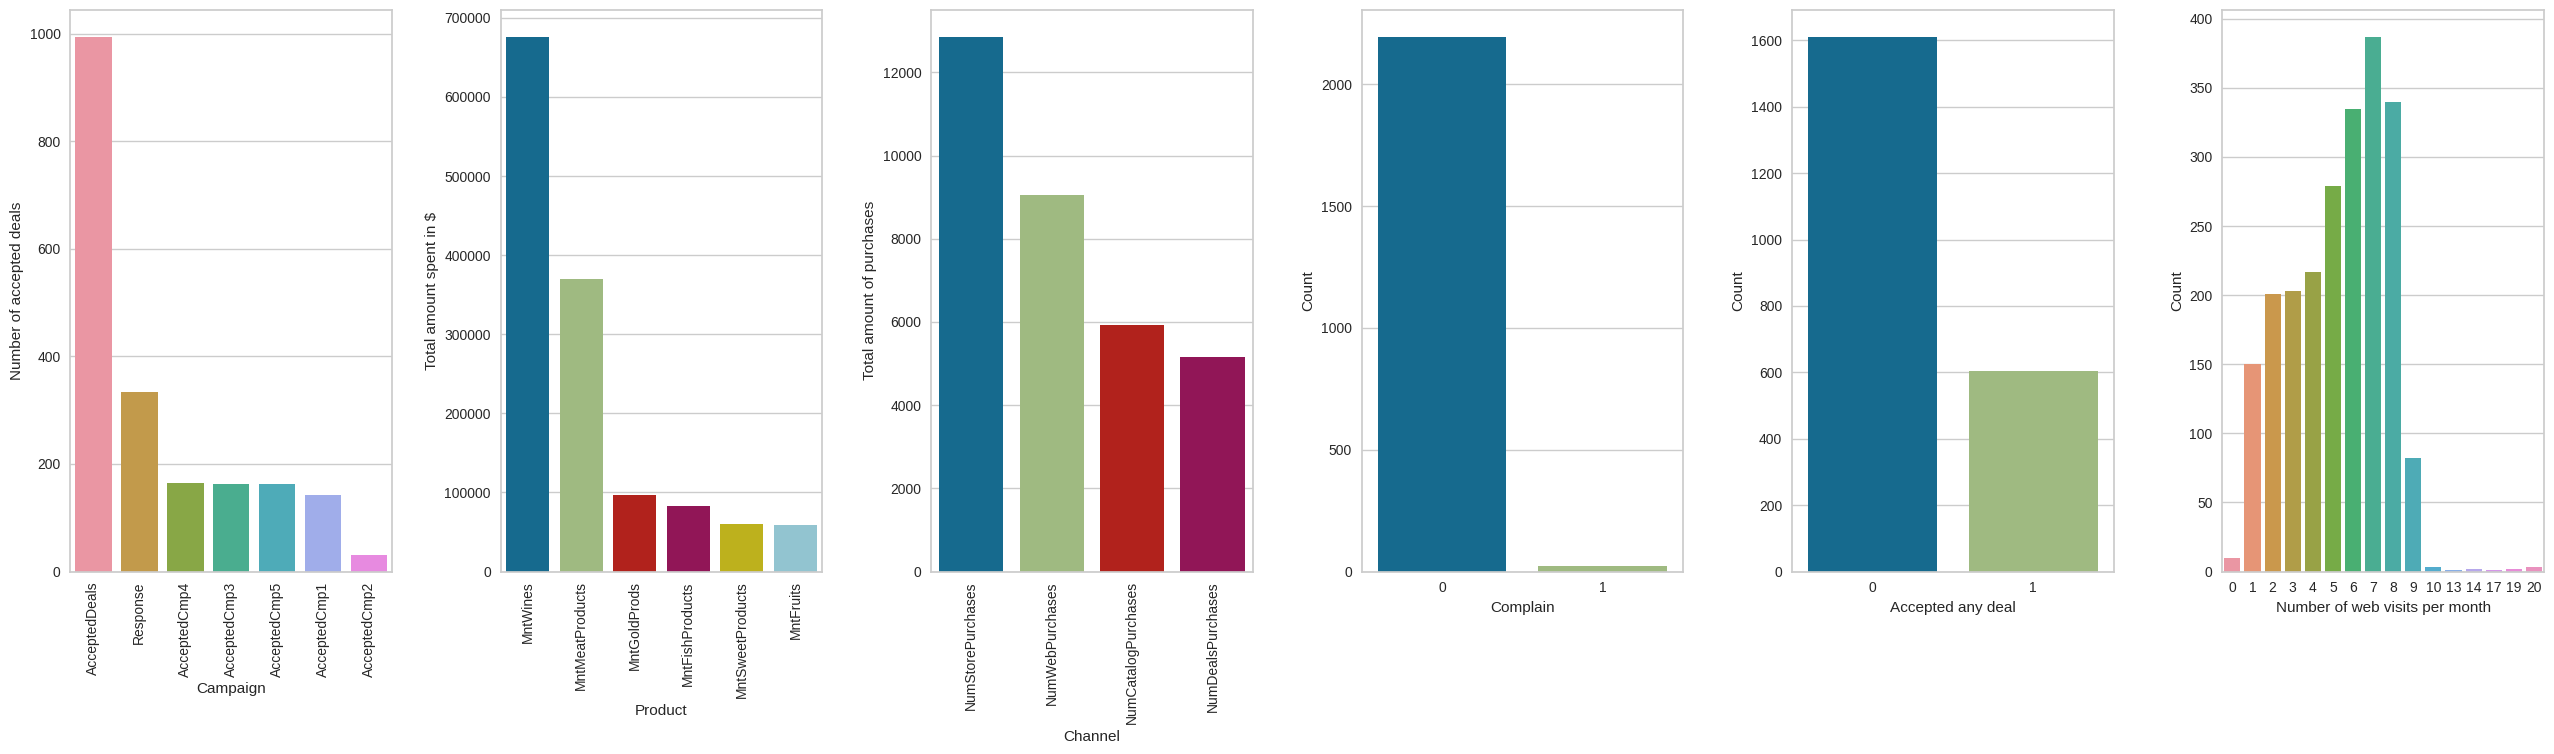

In [55]:
# What was the most succesfull campaign
def percentage(x):
    return x.sum()

campaign_succes = data[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'AcceptedDeals']].agg(percentage)
campaign_succes = campaign_succes.sort_values(ascending=False)
fig, ax = plt.subplots(1, 6, figsize=(26, 8))
# plot
sns.barplot(x=campaign_succes.index, y=campaign_succes, ax=ax[0])
ax[0].set_ylabel('Number of accepted deals')
ax[0].set_xlabel('Campaign')
ax[0].tick_params(axis='x', rotation=90)

# what is thoe most succesfull product?
sum_product = data[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum()   
sum_product = sum_product.sort_values(ascending=False)

# plot
sns.barplot(x=sum_product.index, y=sum_product, ax=ax[1])
ax[1].set_ylabel('Total amount spent in $')
ax[1].set_xlabel('Product')
ax[1].tick_params(axis='x', rotation=90)


# interesting is also whether where the customers bought there products
sum_channel = data[['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum()
sum_channel = sum_channel.sort_values(ascending=False)

sns.barplot(x=sum_channel.index, y=sum_channel, ax=ax[2])
ax[2].set_ylabel('Total amount of purchases')
ax[2].set_xlabel('Channel')
ax[2].tick_params(axis='x', rotation=90)

sns.countplot(data=data, x='Complain', ax=ax[3])   
ax[3].set_ylabel('Count')
ax[3].set_xlabel('Complain')

sns.countplot(data=data, x='AcceptedAnyDeal', ax=ax[4])
ax[4].set_ylabel('Count')
ax[4].set_xlabel('Accepted any deal')

sns.countplot(data=data, x='NumWebVisitsMonth', ax=ax[5])
ax[5].set_ylabel('Count')
ax[5].set_xlabel('Number of web visits per month')

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">

- **Campaign**: The most succesfull campaign seems to be the last one, whereas campaigns 4,3,5,1 seem to be less succesfull but where approx. equaly succeesfull with a successrate of approxiamately 7%. The least successfull camapign was campaign 2, where only 1.5% percent of the people responded to the campaign. 
- **Product**: The product with biggest income for the company was the amount of wine sold. The company earned around 680,000$. Secondly the company eraned around 380,000$ with selleing meat products. The other prpducts gained less then 100k$.

- **Channel**: Most purchases were made in the store . Around 13000.....

- **Complain**: Only around 1% of the customers complained. Without having a comparison and a defintion of what a complain here actually means it is not possible to judge whether this is good or bad.

- **Accepted any deal**: Around 26% of the customers responded to any deals.

- **Number of web visits**: Most customers visited the website around 7 times per month.
<h4>Continous Variables</h4>

</div>


/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

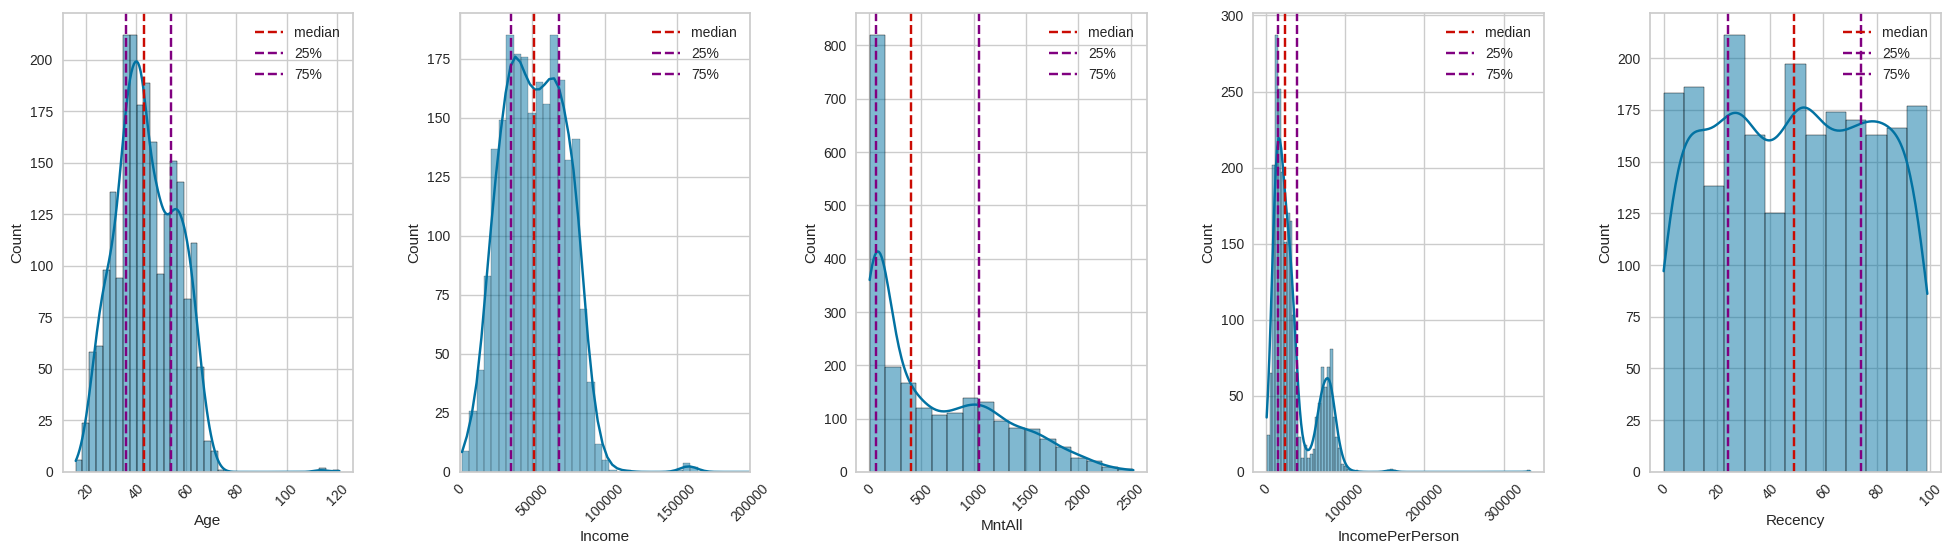

In [43]:
num_cols = ['Age', 'Income', 'MntAll', 'IncomePerPerson', 'Recency']
#num_cols = ['IncomePerPerson','Income']
fig, ax = plt.subplots(1, len(num_cols), figsize=(20, 6))

def median_25_75(x):
    return x.median(), x.quantile(0.25), x.quantile(0.75)

for col in enumerate(num_cols):
    sns.histplot(data=data, x=col[1], ax=ax[col[0]], kde=True)
    median, q25, q75 = median_25_75(data[col[1]])
    ax[col[0]].axvline(median, color='r', linestyle='--', label=f'median')
    ax[col[0]].axvline(q25, color='purple', linestyle='--', label=f'25%')
    ax[col[0]].axvline(q75, color='purple', linestyle='--', label=f'75%')
    ax[col[0]].tick_params(axis='x', rotation=45)
    ax[col[0]].legend()

ax[1].set_xlim(0, 200000)
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">

- **Age**: The median age is about 42 years and looks somewhat normal distributed. There seems to be at least 1 person to have the age of around 110, which is probably an oulier. This datapoint would have anyways not a big statistical significance.

- **Income**: The median income of the customers is about 52k$, appears somewhat normal distributed, and has a quite big interquartile range of 20k$-30k$ between the 25% and 75% percentile. There are also some customers with an income of around 150000$ a year and more. They can be considered outliers as they dont have any statistical significance.

- **IncomePerPerson**: This variable was created by dividing the income with the number of children, to get an approximation for how much money is for a household available. 2 gaussian like distributions seem to make up this distribution. It seems like this transformation is usefull for the clustering. The exact reason why this is is unknown.

- **Recency**: The time of the last purchase seems to be equally distributed ranging from 0 to arround 100 days.

</div>


/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

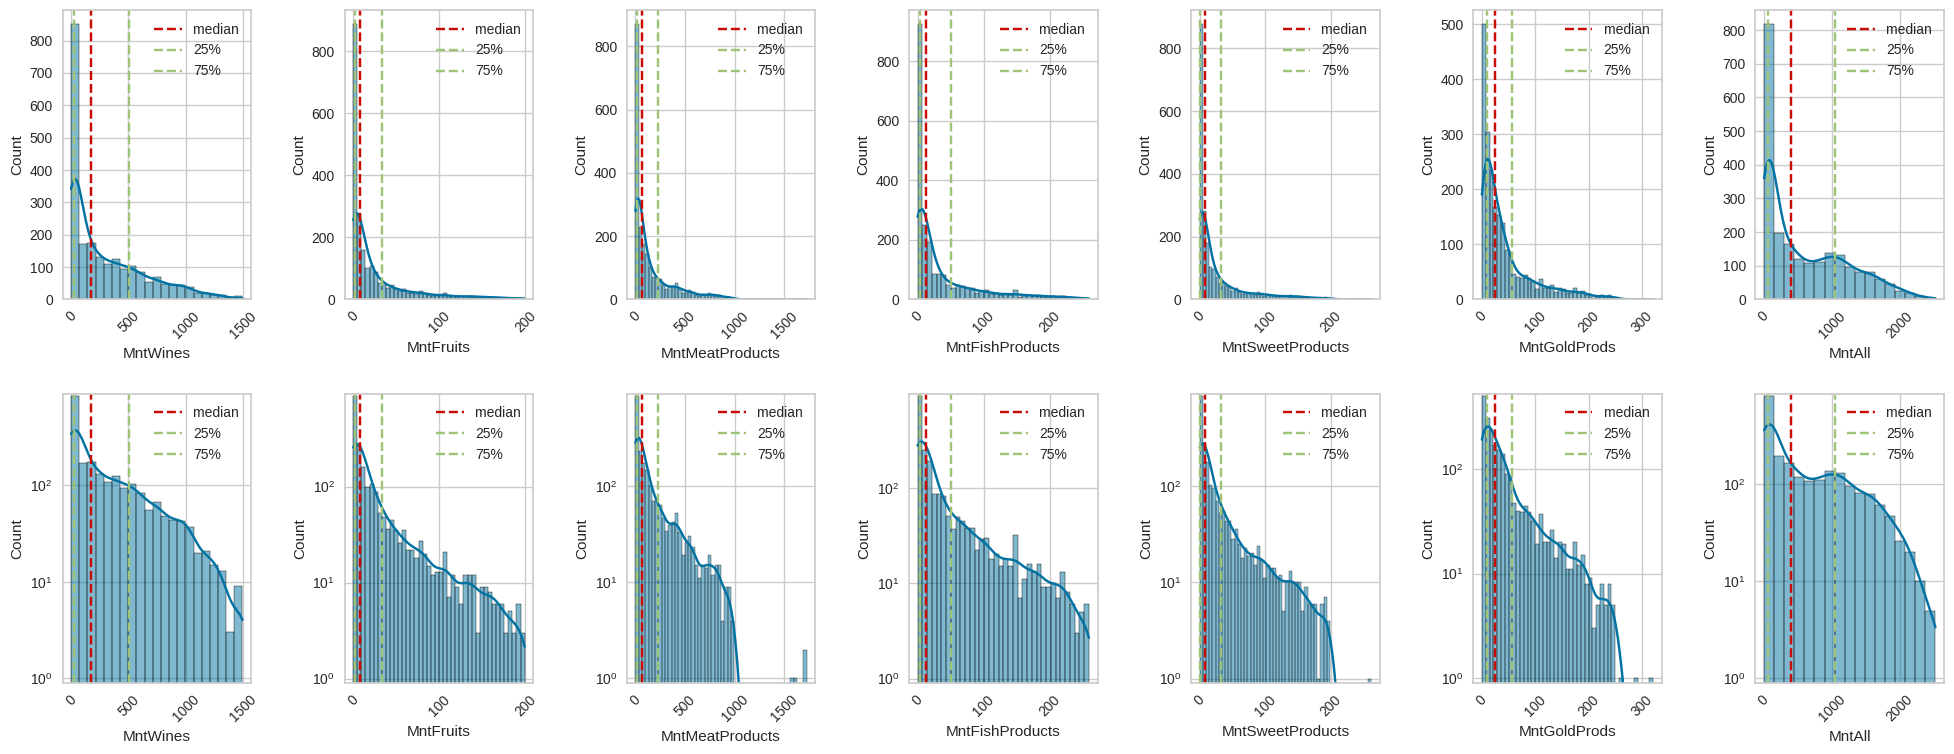

In [44]:
num_cols_mnt = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds','MntAll']

def median_25_75(x):
    return x.median(), x.quantile(0.25), x.quantile(0.75)

fig, ax = plt.subplots(2, len(num_cols_mnt), figsize=(20, 8))  # Creating 2 rows of plots

for i, col in enumerate(num_cols_mnt):
    sns.histplot(data=data, x=col, ax=ax[0, i], kde=True)
    ax[0, i].axvline(data[col].median(), color='r', linestyle='--', label='median')
    ax[0, i].axvline(data[col].quantile(0.25), color='g', linestyle='--', label='25%')
    ax[0, i].axvline(data[col].quantile(0.75), color='g', linestyle='--', label='75%')
    ax[0, i].tick_params(axis='x', rotation=45)
    ax[0, i].legend()

    sns.histplot(data=data, x=col, ax=ax[1, i], kde=True)
    ax[1, i].axvline(data[col].median(), color='r', linestyle='--', label='median')
    ax[1, i].axvline(data[col].quantile(0.25), color='g', linestyle='--', label='25%')
    ax[1, i].axvline(data[col].quantile(0.75), color='g', linestyle='--', label='75%')
    ax[1, i].set_ylim(bottom = 0.9)
    ax[1, i].tick_params(axis='x', rotation=45)
    ax[1, i].set_yscale('log')  # Setting y-scale to logarithmic
    ax[1, i].legend()

plt.tight_layout()
plt.show()


<div class="alert alert-block alert-info">
It is noticable that all the histograms on how much the customers spend have the same appearance. For low spendings the number of customers is the highest, fastly decreases for higher values and then seem to converge for even higher spendings. This is a good hint for an exponential relationship between the spending and the number of customers who spend that much. After applying th logarithm it can be seen, that the spending on the individual products may follow an exponential relationship. But this seems not to apply vor very low spendings and high spendings. This could more investigated but is not done here due to time reasons. The overall spending amount does not follow this relationship anymore. Maybe 2 peaks are visible in this histogram. 1 peak for very low spendings and 1 peak at around 1000$.

Lets take a look at year of birth and date of registration:
</div>

/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


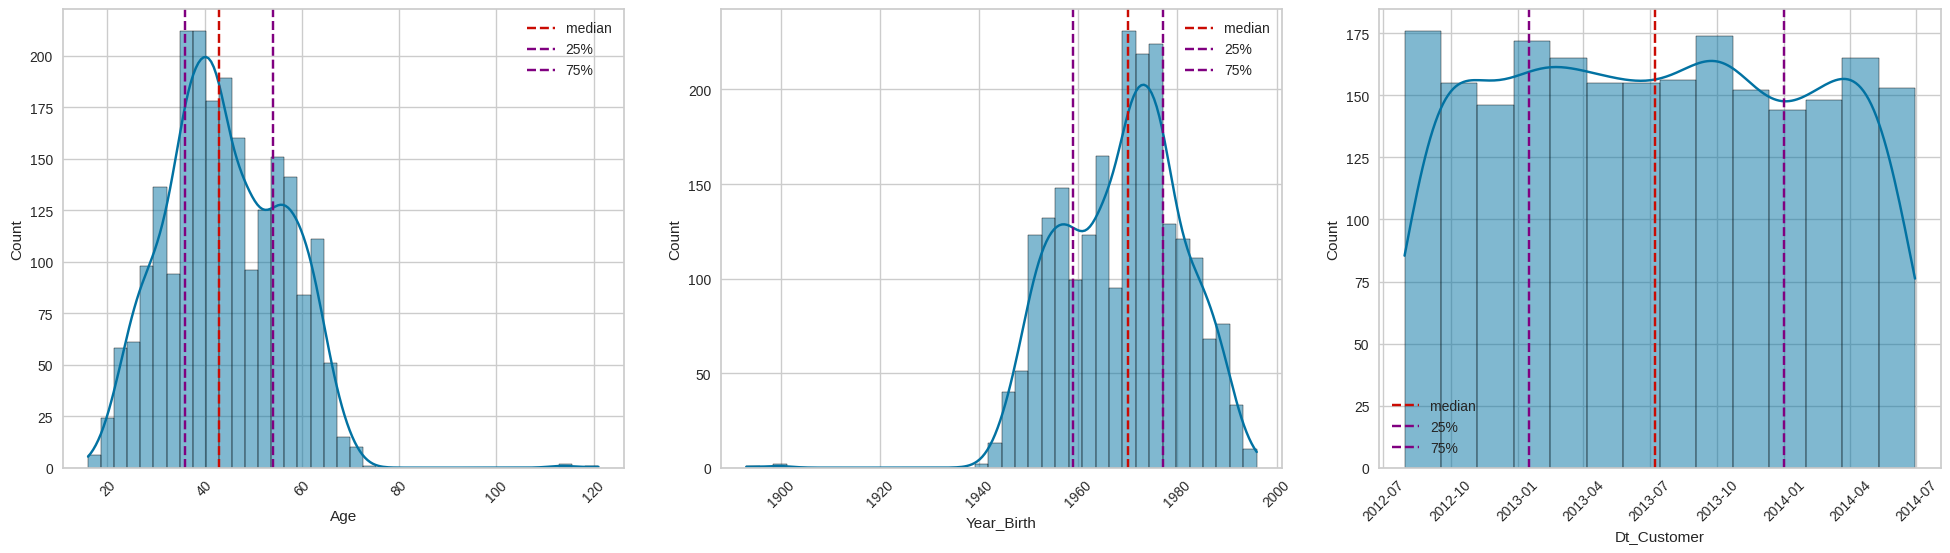

In [45]:
dates = ['Age', 'Year_Birth', 'Dt_Customer']
#num_cols = ['IncomePerPerson','Income']
fig, ax = plt.subplots(1, len(dates), figsize=(20, 6))

def median_25_75(x):
    return x.median(), x.quantile(0.25), x.quantile(0.75)

for col in enumerate(dates):
    sns.histplot(data=data, x=col[1], ax=ax[col[0]], kde=True)
    median, q25, q75 = median_25_75(data[col[1]])
    ax[col[0]].axvline(median, color='r', linestyle='--', label=f'median')
    ax[col[0]].axvline(q25, color='purple', linestyle='--', label=f'25%')
    ax[col[0]].axvline(q75, color='purple', linestyle='--', label=f'75%')
    ax[col[0]].tick_params(axis='x', rotation=45)
    ax[col[0]].legend()

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">

- **Age**: Already discussed

- **Year_Birth**: The median age of birth is at around 1970 and rages from the 1940s to the late 90s. It can be seen that there is also one date of birth at aroud 1900 existend which is very unlikely and threfore considered an outlier. 

- **Dt_Customer**: The date of registering seems equaly distributed. It can be conlcuded the company did not grow in 2 years of data augmentation, since the number of registration is probably somewhat proportional to the succes of the company.

Lets take a look at the revenue costs and contact costs.

</div>

/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


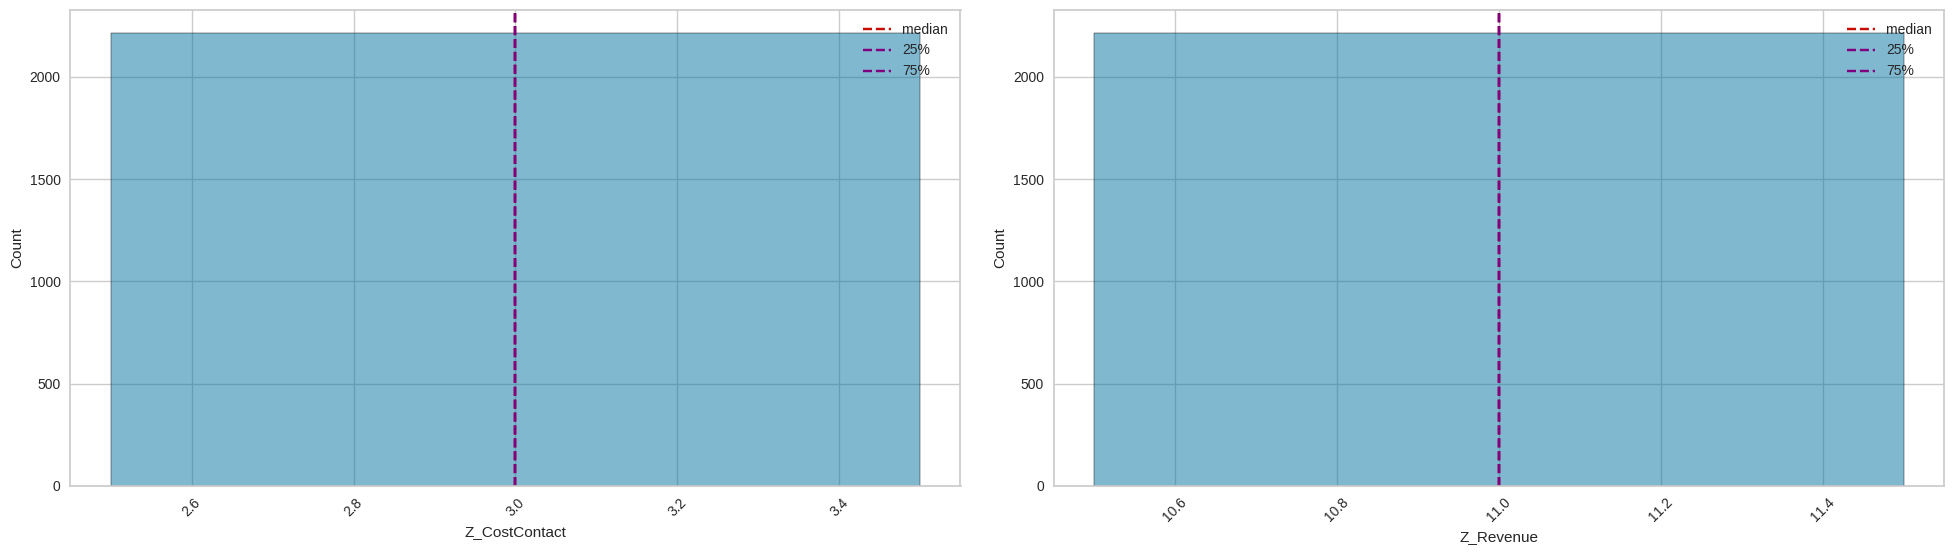

Number of unique values for Z_CostContact: 1 Number of unique values for Z_Revenue: 1


In [46]:
loc = ['Z_CostContact', 'Z_Revenue']
#num_cols = ['IncomePerPerson','Income']
fig, ax = plt.subplots(1, len(loc), figsize=(20, 6))

def median_25_75(x):
    return x.median(), x.quantile(0.25), x.quantile(0.75)

for col in enumerate(loc):
    sns.histplot(data=data, x=col[1], ax=ax[col[0]], kde=True)
    median, q25, q75 = median_25_75(data[col[1]])
    ax[col[0]].axvline(median, color='r', linestyle='--', label=f'median')
    ax[col[0]].axvline(q25, color='purple', linestyle='--', label=f'25%')
    ax[col[0]].axvline(q75, color='purple', linestyle='--', label=f'75%')
    ax[col[0]].tick_params(axis='x', rotation=45)
    ax[col[0]].legend()

plt.tight_layout()
plt.show()

print('Number of unique values for Z_CostContact: {}'.format(data['Z_CostContact'].nunique()), 'Number of unique values for Z_Revenue: {}'.format(data['Z_Revenue'].nunique()))

<div class="alert alert-block alert-info">
It can be seen, that the attributes Z_CostContact and Z_Revenue are everywhere the same. Therefore they are nto relevant for the clustering and further analysis.
</div>

<div class="alert alert-block alert-info">
<h4>Bivariat and Multivariat Analysis</h4>

Now we will investigate with a scatterplot how the total spend amount is related to other numerical variables.
</div>

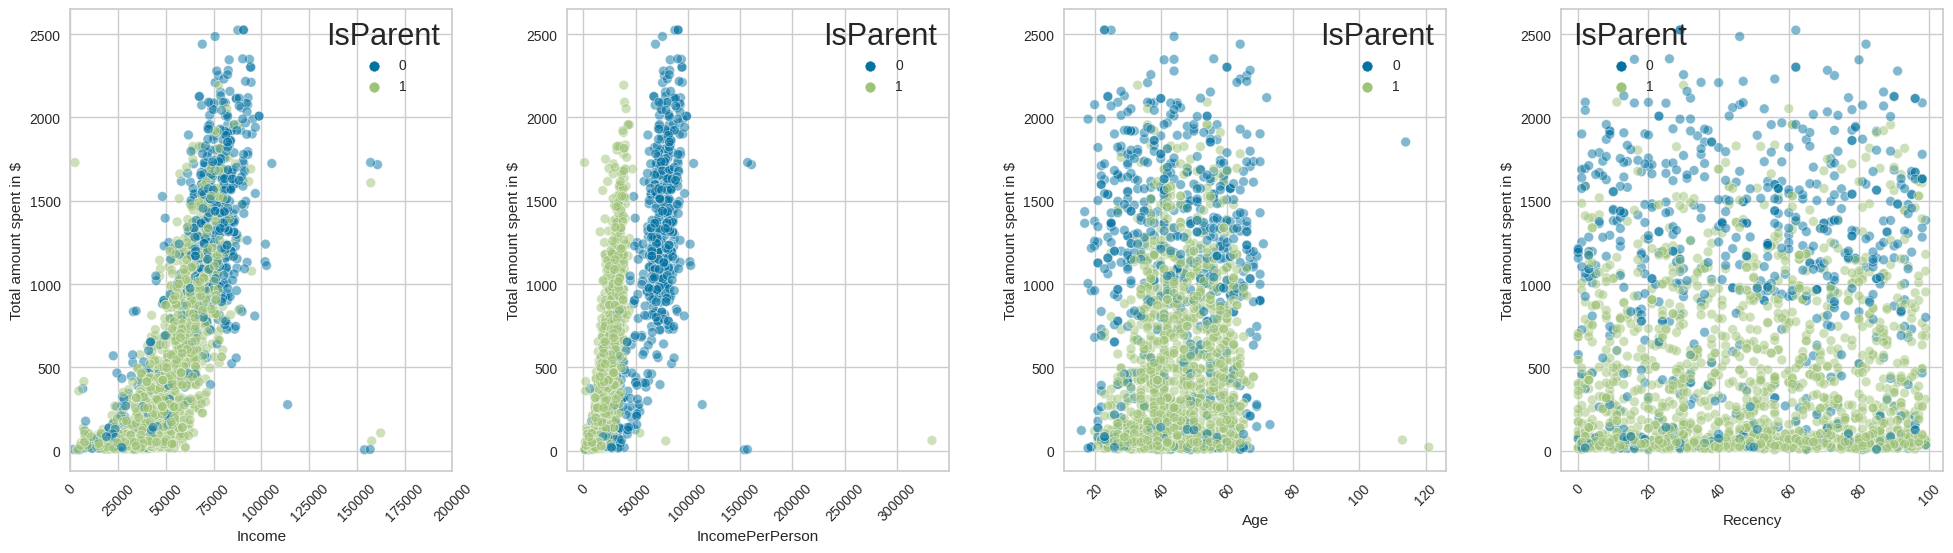

In [77]:
# i want to plot num_cols_pair agaings mntalll
num_cols_pair = ['Income', 'IncomePerPerson', 'Age', 'Recency']
hue = 'IsParent'
fig, ax = plt.subplots(1, len(num_cols_pair), figsize=(20, 6))
for col in enumerate(num_cols_pair):
    sns.scatterplot(data=data, x=col[1], y='MntAll', hue=hue, ax=ax[col[0]], alpha = 0.5)
    ax[col[0]].set_ylabel('Total amount spent in $')
    ax[col[0]].set_xlabel(col[1])
    ax[col[0]].tick_params(axis='x', rotation=45)
ax[0].set_xlim(0, 200000)
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<h4>Bivariat and Multivariat Analysis</h4>

- **Income**: It can be seen that the customers tend to spend more money when they have a bigger income. Parents tend to spend less.
- **ImcomePerPerson**: It can be seen that my newly derived variable can seperate Parents from non parents wuite well. 
- **Age**: Interestingly the age does not influence the total spending amount so much
- **Recency**: Also the recency does not influence the overall spending amount.
</div>

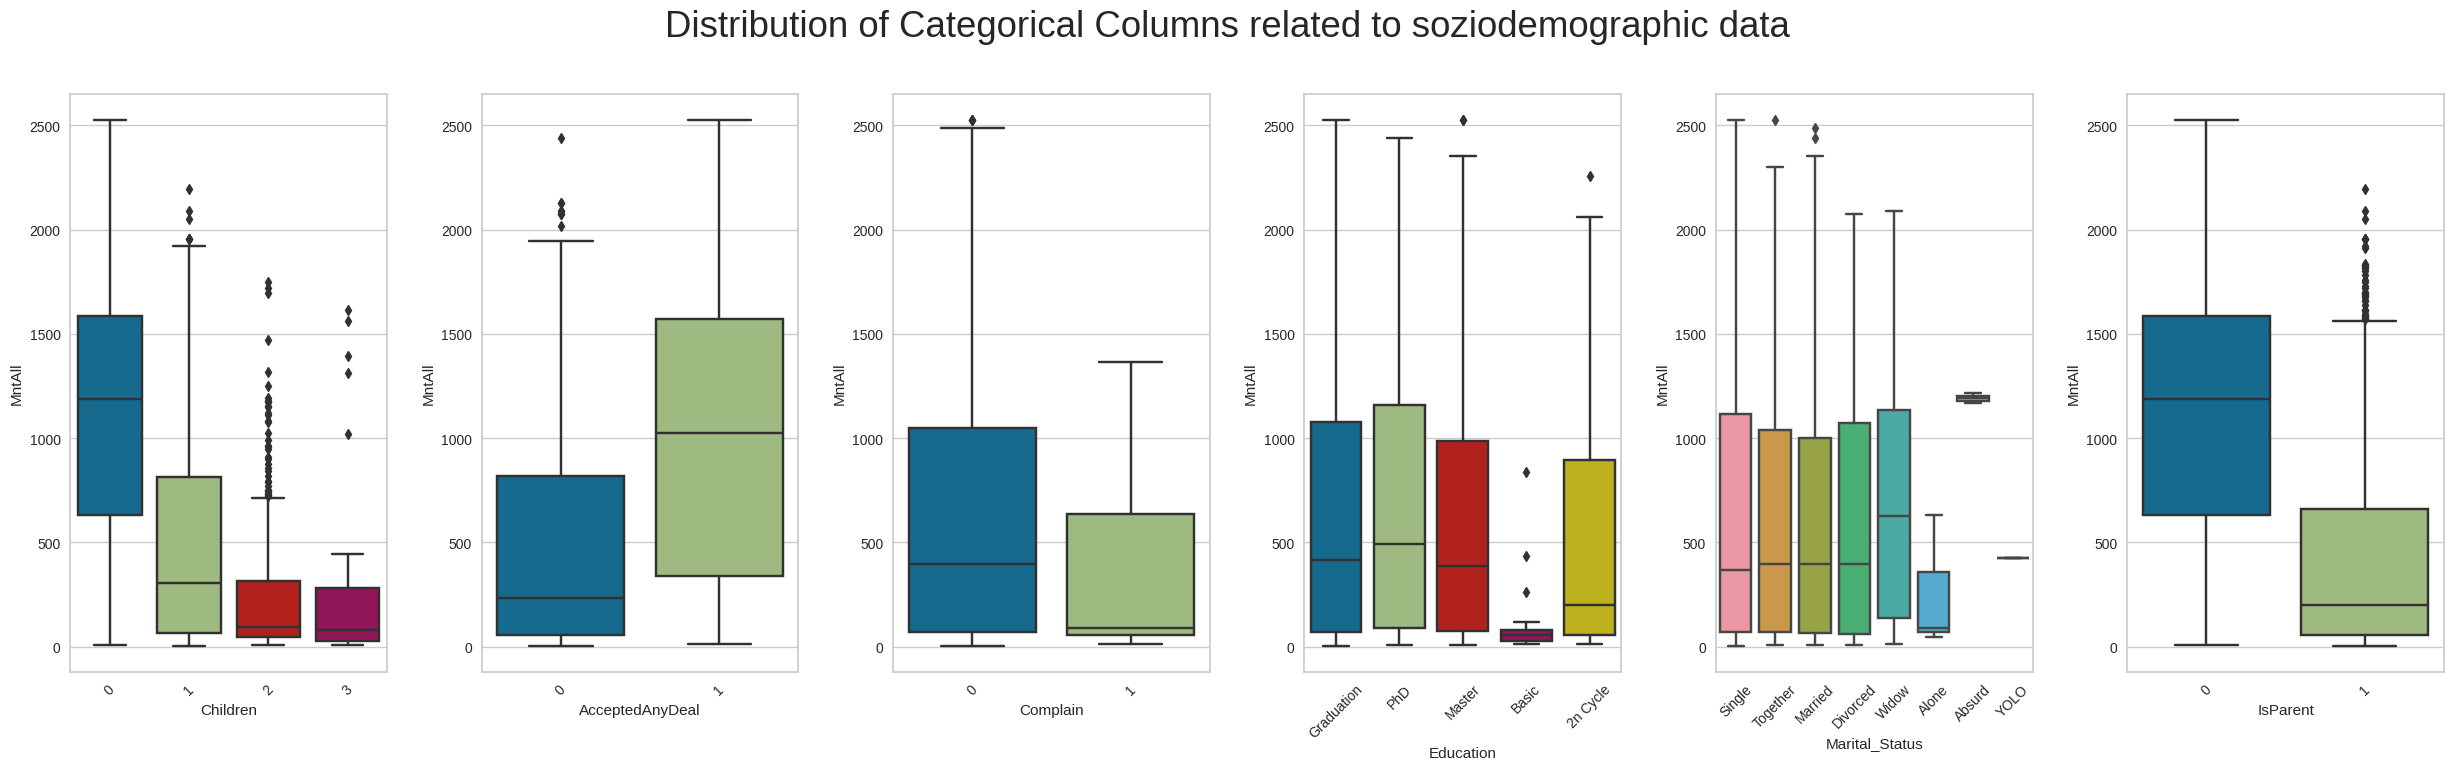

In [68]:
# some nice violin plots
cat2_var = ['Children', 'AcceptedAnyDeal', 'Complain', 'Education', 'Marital_Status', 'IsParent']
y = 'MntAll'
fig, ax = plt.subplots(1, len(cat2_var), figsize=(25, 8))
fig.suptitle('Distribution of Categorical Columns related to soziodemographic data')
for col in enumerate(cat2_var):
    sns.boxplot(data=data, x=col[1], y=y, ax=ax[col[0]])
    ax[col[0]].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
correlation...
</div>

<div class="alert alert-block alert-info">

Correlation matrix. This i will put in the PCA part.

</div>

<div class="alert alert-block alert-info">
The registrations of customers stayed constant over the time. This means that the business probably did not grow in the two years.

### numeric variables vs categorial variables
</div>

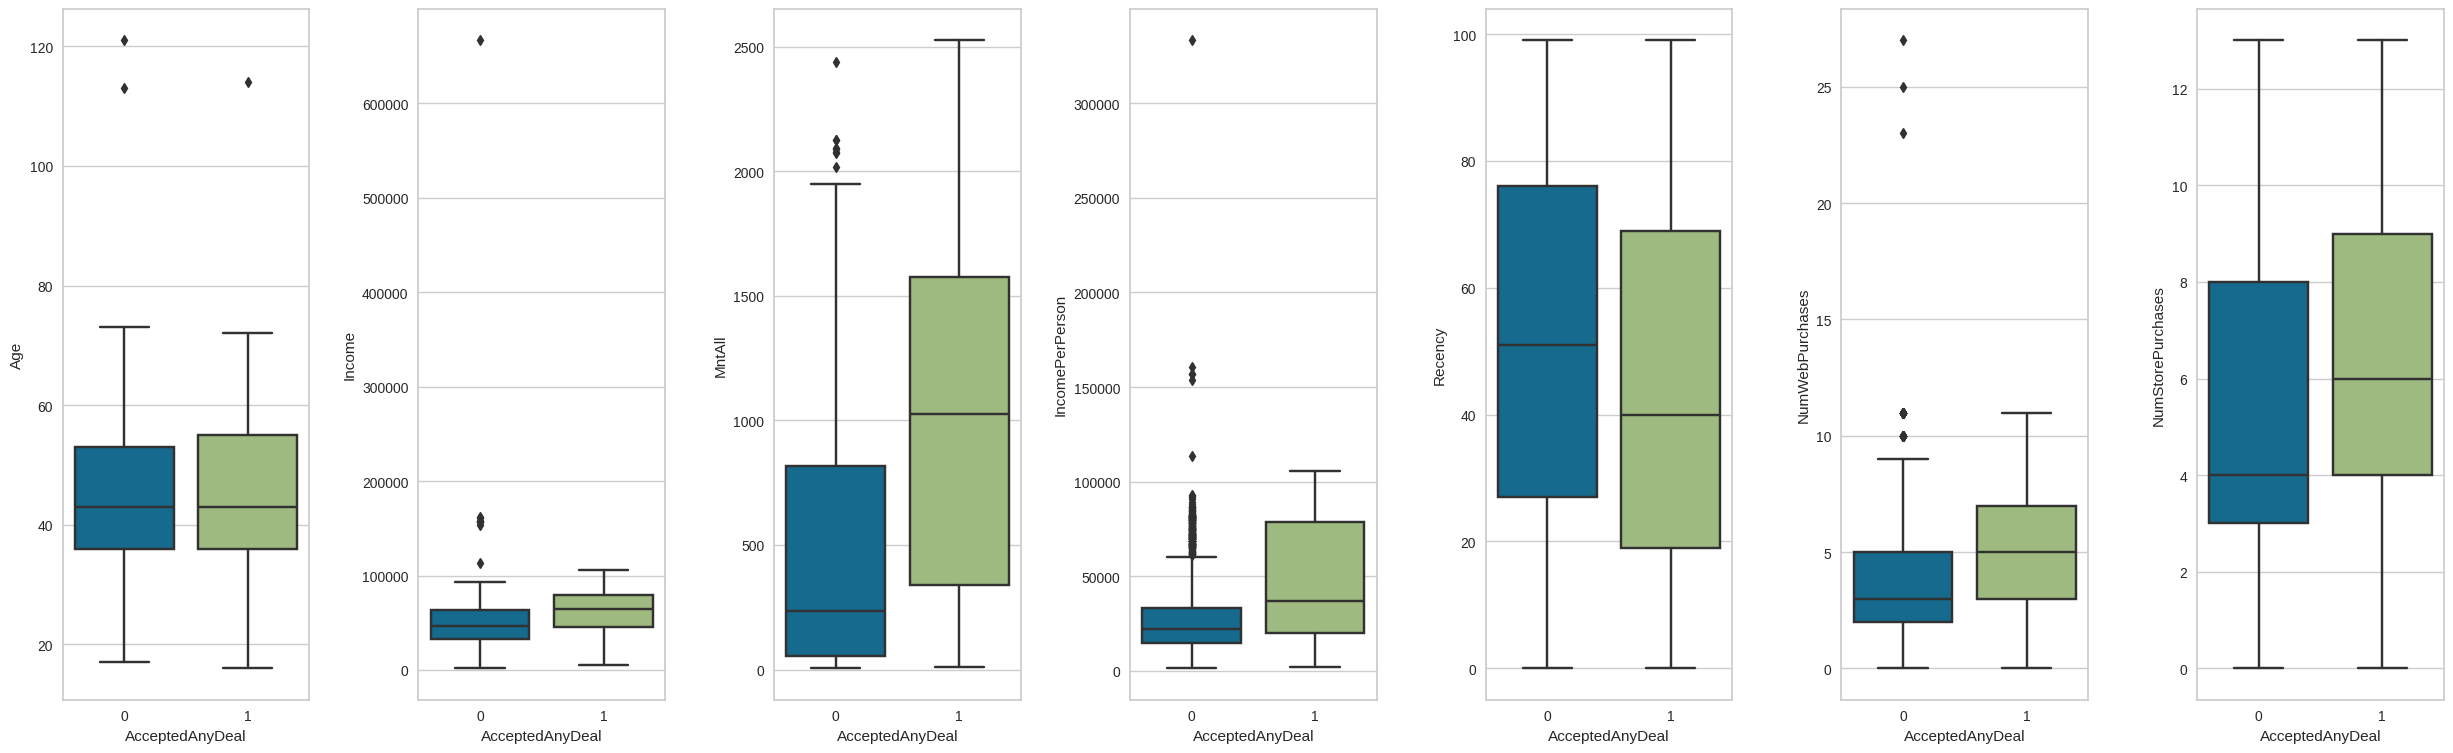

In [79]:
# ### hole spending amount vs. AcceptedAnyDeal in a violinplot
num_cols = ['Age', 'Income', 'MntAll', 'IncomePerPerson', 'Recency', 'NumWebPurchases','NumStorePurchases']
accepted_deal = 'AcceptedAnyDeal'

fig, ax = plt.subplots(1, len(num_cols), figsize=(25, 8))
for col in enumerate(num_cols):
    sns.boxplot(data=data, x=accepted_deal,y=col[1], ax=ax[col[0]])

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<h2>Clustering</h2>
</div>

<div class="alert alert-block alert-info">
<h3>Special encoding of the attributes</h3>

Education:
- The degree of completion can be considered both ordinal and cardinal. The order of the level of the degree is selected. On ehot encding is used.

Marital_Status:
- The Marital_Status with entries like Divorced, Married, Single, etc... can not be ordinal encoded. Therefore one hot encoding takes place here.

The other attributes are numerical or binary and can therefore be used as they are.

</div>

In [50]:
data.columns

Index(['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Age', 'MntAll', 'Children', 'IsParent', 'AcceptedDeals',
       'AcceptedAnyDeal', 'LivingTogether', 'IncomePerPerson'],
      dtype='object')

array([[ 4.49800769,  0.10224013, -1.48178015],
       [-2.87442732,  0.36786834,  1.53138989],
       [ 2.4493419 , -0.68188535,  0.29311899],
       ...,
       [ 2.19228344, -0.98310962, -0.32685946],
       [ 1.79354186,  1.32537694,  1.28775683],
       [-2.35625941,  1.26218012,  0.79518448]])

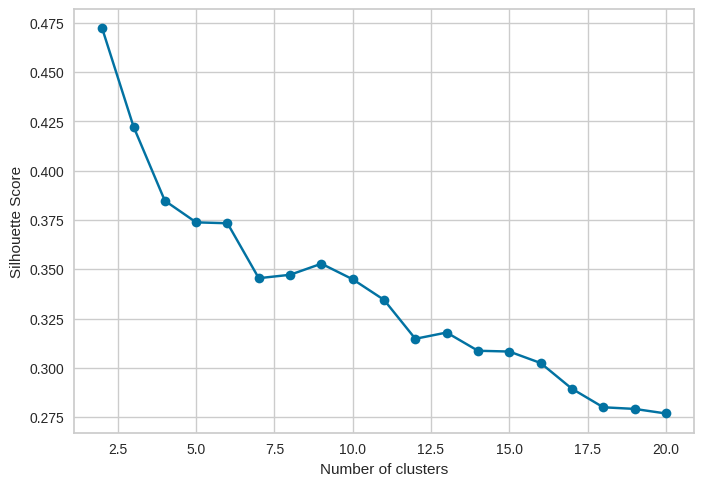

/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


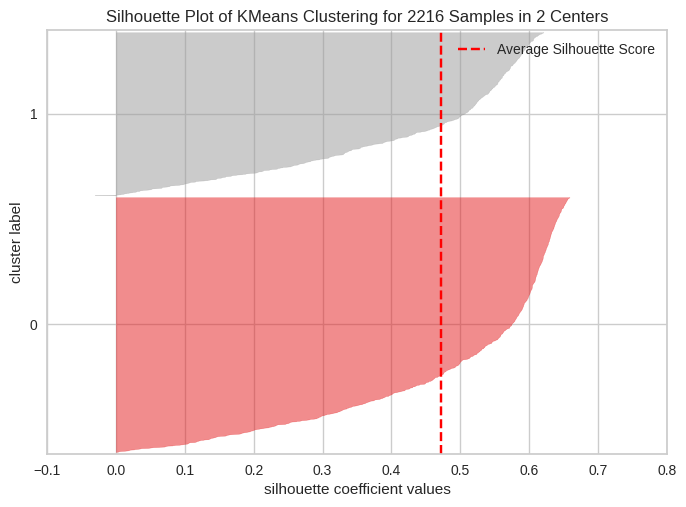

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score
# pricipal component analysis
from sklearn.decomposition import PCA

# drop the columns with nan
data.dropna(inplace=True)
num_cols = ['Income', 'Kidhome',
       'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 
       'Age', 'MntAll', 'Children', 'IncomePerPerson']

cat_cols = ['Education', 'Marital_Status', 'AcceptedAnyDeal']

bin_col = [ 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'IsParent', 'LivingTogether']

class KMEANS_Wrapper:
    def __init__(self,data, num_cols, cat_cols, bin_cols, min_clusters=1, max_clusters=20, n_components=3, pca = False):
        self.data = data
        self.min_clusters = min_clusters
        self.max_clusters = max_clusters
        self.num_cols = num_cols
        self.cat_cols = cat_cols
        self.bin_cols = bin_cols
        self.n_components = n_components
        self.pca = pca

        # used attributes:
        self.used_attributes = self.num_cols + self.cat_cols + self.bin_cols

    def pca_features(self, X, n_components = 3):
        self.pca = PCA(n_components=n_components)
        return self.pca.fit_transform(X)

    def prep_fit_evaluate(self):
        self.X = self.preprocessor()
        if self.pca:
            self.X = self.pca_features(self.X, self.n_components)
            display(self.X)
        self.find_optimal_clusters(self.X)
        self.plot_optimal_cluster_knee()

    def preprocessor(self):
        num_pipeline = Pipeline([
            ('scaler', StandardScaler())
        ])
        cat_pipeline = Pipeline([
            ('encoder', OneHotEncoder())
        ])
        preprocessor = ColumnTransformer([
            ('num_scaler', num_pipeline, self.num_cols),
            ('cat_onehot', cat_pipeline, self.cat_cols)
        ])
        return preprocessor.fit_transform(self.data)
    
    def find_optimal_clusters(self, data):
        self.silhouette_scores = []
        for i in range(self.min_clusters, self.max_clusters+1):
            model = KMeans(n_clusters=i, random_state=42, n_init=10, max_iter=1000)
            silhouette = silhouette_score(data, model.fit_predict(data))
            self.silhouette_scores.append(silhouette)
    
    def plot_optimal_cluster_knee(self):
        plt.plot(range(self.min_clusters, self.max_clusters+1),self.silhouette_scores, marker='o')
        plt.xlabel('Number of clusters')
        plt.ylabel('Silhouette Score')
        plt.show()

    def silhouette_plot(self, n_cluster = 1):
        model = KMeans(n_clusters=n_cluster, random_state=42)
        visualizer = SilhouetteVisualizer(model)
        visualizer.fit(self.X)
        visualizer.show()

    def fit(self, data):
        X = self.preprocessor(data)
        X = self.select_features(X)
        self.model.fit(X)
    
    def dim_reduction(self, data):
        # before using 
        X = self.preprocessor(data)
        X = self.select_features(X)
        return self.pca.transform(X)
    
model = KMEANS_Wrapper(data = data, num_cols=num_cols, cat_cols=cat_cols, bin_cols=bin_col, min_clusters=2, max_clusters=20, n_components=3, pca=True)
model.prep_fit_evaluate()
model.silhouette_plot(n_cluster=2)


/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


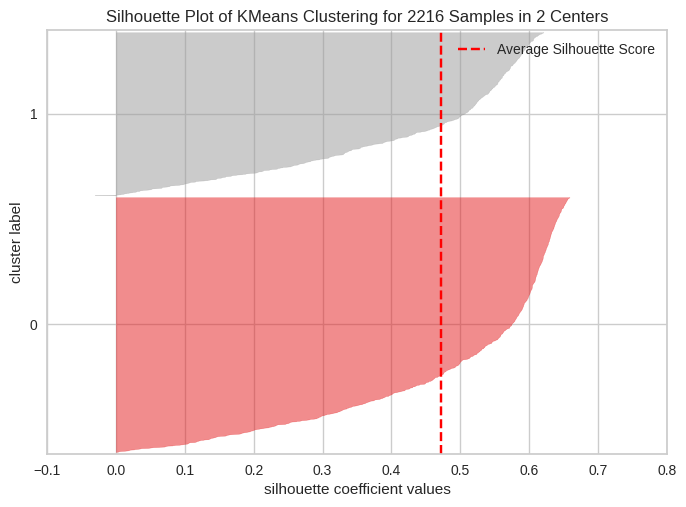

/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


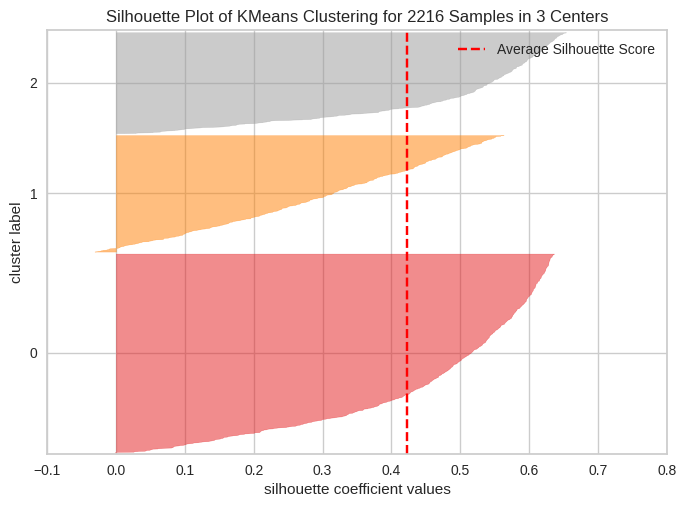

/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


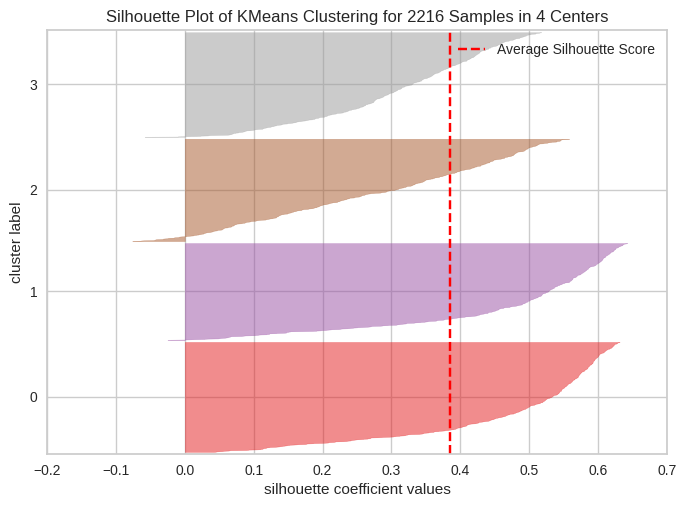

/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


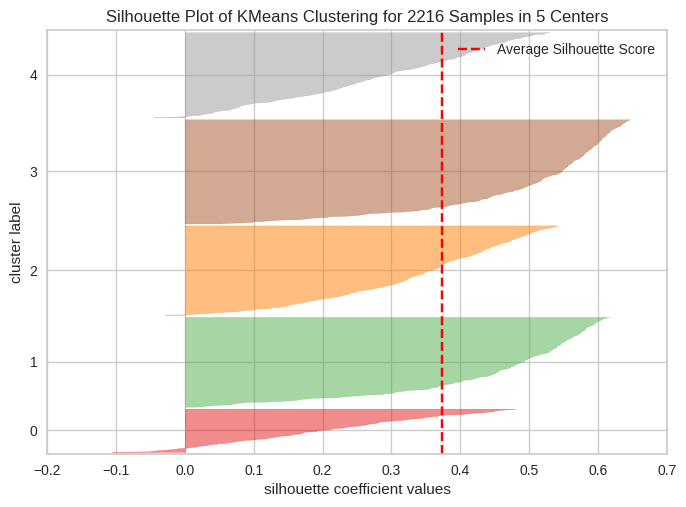

In [52]:
for i in range(2, 6):
    model.silhouette_plot(n_cluster=i)
    plt.show()

<div class="alert alert-block alert-info">
It can be seen that the clustering of all attributes was not succesfull. This siohouette score is very low. Only a weak till no structure is existent.
</div>
